In [1]:
from IPython.display import display, HTML #make wider
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature import COASTLINE
from scipy.stats import binned_statistic_2d
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import FormatStrFormatter 
from matplotlib.ticker import MaxNLocator  # Import MaxNLocator
from matplotlib.path import Path
import os

#####################################################################################################
# convert to (-180, 180) | year-range selection | domain selection ##################################
def trans_trim_dframe(df, lon_col='LON', lat_col='LAT', time_col='ISO_TIME', start_year=None, end_year=None, lon_min=None, lon_max=None, lat_min=None, lat_max=None):
    # Transform 'LON' values to (-180, 180) range
    df[lon_col] = df[lon_col].apply(lambda lon: lon if lon <= 180 else lon - 360)

    # Extract the years from the "ISO_TIME" column
    df['YEAR'] = pd.to_datetime(df[time_col]).dt.year

    # Filter data for the needed years
    if start_year is not None and end_year is not None:
        y_range = range(start_year, end_year + 1)
        df = df[df['YEAR'].isin(y_range)]

    # Filter data for the specified region
    if lon_min is not None and lon_max is not None and lat_min is not None and lat_max is not None:
        df = df[(df[lon_col] >= lon_min) & (df[lon_col] <= lon_max) &
                (df[lat_col] >= lat_min) & (df[lat_col] <= lat_max)]

    return df

###############################################################################################

def point_in_polygon(lon, lat, polygon_path):
    return polygon_path.contains_point((lon, lat))

def basin_data(in_df, basin=None):
    
    # Read the dataframe
    df = in_df
    
    # Convert longitude values from [0, 360) to [-180, 180)
    df['LON'] = (df['LON'] + 180) % 360 - 180

    # Check if basin is provided
    if basin is not None:
        # Define the polygon coordinates based on the provided basin
        
        if basin == 'Glb':
            polygon_coords = np.array([[-180, 50], [-180, -50], [180, -50], [180, 50], [-180, 50]])
            
        elif basin == 'NA':
            polygon_coords = np.array([[-70, 0], [-100, 20], [-100, 50], [0, 50], [0, 0], [-70, 0]])
            
        elif basin == 'EP':
            polygon_coords = np.array([[-70, 0], [-100, 20], [-100, 50], [-180, 50], [-180, 0], [-70, 0]])            
            
        elif basin == 'WNP': 
            polygon_coords = np.array([[100, 0], [100, 50], [180, 50], [180, 0], [100, 0]]) 
            
        elif basin == 'NI': 
            polygon_coords = np.array([[30, 0], [30, 50], [100, 50], [100, 0], [30, 0]]) 

        elif basin == 'SI': 
            polygon_coords = np.array([[10, 0], [10, -50], [135, -50], [135, 0], [10, 0]])            

        elif basin == 'SA': 
            polygon_coords = np.array([[10, 0], [10, -50], [-70, -50], [-70, 0], [10, 0]]) 

        elif basin == 'SP':  # this is special case. So, coordinate in 0 to 360 form
            polygon_coords = np.array([[135, 0], [135, -50], [290, -50], [290, 0], [135, 0]]) 

        # Create the polygon path
        polygon_path = Path(polygon_coords)

        # Filter rows based on the condition      
        if basin == 'SP':
            
            # Convert longitude values from [-180, 180] to [0, 360] before applying mask
            df['LON'] = (df['LON'] + 360) % 360 
            
            mask = df.apply(lambda row: point_in_polygon(row['LON'], row['LAT'], polygon_path), axis=1)
            filtered_df = df[mask]
    
            # Convert longitude values from back to [-180, 180]
            filtered_df['LON'] = (filtered_df['LON'] + 180) % 360 - 180
            
        else:
            mask = df.apply(lambda row: point_in_polygon(row['LON'], row['LAT'], polygon_path), axis=1)
            filtered_df = df[mask]
            
        return filtered_df
    # If basin is not provided, return the original DataFrame
    return df



In [3]:
# Load the datasets
sub_data_1 = pd.read_csv('../Data/IBTrACS_[Bourdin2022].csv')
sub_data_2 = pd.read_csv('../Data/IBTrACS_[JTWC+HURDAT].csv')
sub_data_3 = pd.read_csv('../Data/f3L_w15.2_Walsh.csv')
sub_data_4 = pd.read_csv('../Data/f3H_w17.1_Walsh.csv')
sub_data_5 = pd.read_csv('../Data/f3HH_w17.4_Walsh.csv')

exp_name_1 = 'IB-B22'
exp_name_2 = 'JT+HR'
exp_name_3 = 'f3-L'
exp_name_4 = 'f3-H'
exp_name_5 = 'f3-HH'

start_year = 1998
end_year = 2007

# Define the global domain first (this is just to initiate trimming, later BASIN-WISE will consider)
lon_min, lon_max = -180, 180
lat_min, lat_max = -50, 50

basins = ['Glb', 'NA', 'NI', 'SI', 'SA', 'WNP', 'EP', 'SP']

cri = 2   # 0-Liu, 1-CMA, 2-SS

# Define the grid resolution for track density
grid_resolution = 2      # 1,2,5 degree typically
common_max_fvalue = 5    # This is for color scale, this value based on your data

# To filter data for the needed years
y_range = range(start_year, end_year+1)

# Ready to go ....

# Apply the function to each sub_data DataFrame
# convert to (-180, 180) | year-range selection | domain selection ##############################

sub_data_1 = trans_trim_dframe(sub_data_1, start_year=start_year, end_year=end_year, lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max)
sub_data_2 = trans_trim_dframe(sub_data_2, start_year=start_year, end_year=end_year, lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max)
sub_data_3 = trans_trim_dframe(sub_data_3, start_year=start_year, end_year=end_year, lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max)
sub_data_4 = trans_trim_dframe(sub_data_4, start_year=start_year, end_year=end_year, lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max)
sub_data_5 = trans_trim_dframe(sub_data_5, start_year=start_year, end_year=end_year, lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max)

/tmp/ipykernel_1971/4088208449.py:2: DtypeWarning: Columns (21,66,128,143) have mixed types. Specify dtype option on import or set low_memory=False.
  sub_data_1 = pd.read_csv('../Data/IBTrACS_[Bourdin2022].csv')
/tmp/ipykernel_1971/4088208449.py:3: DtypeWarning: Columns (21,66,128,143) have mixed types. Specify dtype option on import or set low_memory=False.
  sub_data_2 = pd.read_csv('../Data/IBTrACS_[JTWC+HURDAT].csv')


In [4]:
# Data sources to loop over
sources = [sub_data_1, sub_data_2, sub_data_3, sub_data_4, sub_data_5]
exp_names = ['IB-B22M2', 'JT+HD-NR', 'f3-L (~100km)', 'f3-H (~25km)', 'f3-HH (~12.5km)']
colors = ['k', 'b', 'g', 'r', 'm', 'y',  'indigo']

# Define a dictionary to store scount_values for each case
scount_values_dict = {}

# List of mstep values to iterate over
mstep_values = [4, 12]  # 4, 6, 8, 12, 16, 20

# Define the cases to iterate over
cases = [1.9, 2.9, 3.9, 4.9, 5.9, 6.9]

# Define sub_data variables as a dictionary
sub_data_dict = {f'sub_data_{i}': pd.DataFrame() for i in range(1, len(sources)+1)}


In [5]:
# Create a 4D array to store scount values for each mstep and experiment
scount_values_4D = np.zeros( (len(mstep_values), len(cases), len(basins), 5) )  # 5 experiments   

# Iterate over mstep values    
for mstep_idx, mstep in enumerate(mstep_values):
      
    # Iterate over cases
    for case_idx, case in enumerate(cases):        

        for i, sub_data in enumerate([sub_data_1, sub_data_2, sub_data_3, sub_data_4, sub_data_5], 
                                     start=1):

            # NECESSARY to make sure no residuals from previous
            filtered_data = pd.DataFrame() 

            # simple filtering logic   # 'mstep' and 'case' tasks are done
            if not sub_data.empty and 'SID' in sub_data.columns:
                for storm_id, storm_d in sub_data.groupby('SID'):
                    if len(storm_d) >= mstep and (storm_d['UNI_CAT'] >= case).any():
                        filtered_data = filtered_data.append(storm_d)  

            # Update the filtered data variable in sub_data_dict
            sub_data_dict[f'sub_data_{i}'] = filtered_data
                                   

        # Iterate over basins
        for basin_idx, basin in enumerate(basins):                                    
                                                             
            for i, (sub_data_key, exp_name) in enumerate(zip(sub_data_dict.keys(), [exp_name_1, exp_name_2, exp_name_3, exp_name_4, exp_name_5]) ):

                if i != 'NaN' :   # incase of need to Skip a subplot (index i)
                    
                    # Basin Selection  # 'basin' task is done               
                    if not sub_data_dict[sub_data_key].empty:                     
                        sub_data = basin_data(sub_data_dict[sub_data_key], basin)             
                    else:
                        sub_data = pd.DataFrame() 

                        
                    # simple count  # 'count' task is done
                    scount = 0                   
                    if not sub_data.empty and 'SID' in sub_data.columns:
                        for storm_id, storm_d in sub_data.groupby('SID'):
                            if len(storm_d) >= 1 and (storm_d['UNI_CAT'] >= case).any():
                                scount += 1                   
                                       
                    # Store scount value in the array
                    scount_values_4D[mstep_idx, case_idx, basin_idx, i] = scount

        print(scount_values_4D)    
        # Store scount_values for the current case in the dictionary
        scount_values_dict[case] = scount_values_4D

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2606167707.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['LON'] = (filtered_df['LON'] + 180) % 360 - 180
/tmp/ipykernel_1971/2606167707.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['LON'] = (filtered_df['LON'] + 180) % 360 - 180
/tmp/ipykernel_1971/2606167707.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

[[[[8.160e+02 7.800e+02 8.510e+02 1.080e+03 1.054e+03]
   [1.480e+02 1.480e+02 1.450e+02 2.090e+02 1.880e+02]
   [4.400e+01 3.600e+01 5.400e+01 1.100e+02 9.400e+01]
   [1.710e+02 1.640e+02 1.420e+02 1.460e+02 1.580e+02]
   [1.000e+00 0.000e+00 2.000e+00 9.000e+00 4.000e+00]
   [2.300e+02 2.260e+02 3.280e+02 3.620e+02 3.460e+02]
   [1.370e+02 1.370e+02 7.000e+01 1.380e+02 1.200e+02]
   [1.000e+02 8.500e+01 1.350e+02 1.430e+02 1.730e+02]]

  [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
   [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
   [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
   [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
   [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
   [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
   [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
   [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]]

  [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
   [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
   [0.

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2606167707.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['LON'] = (filtered_df['LON'] + 180) % 360 - 180
/tmp/ipykernel_1971/2606167707.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['LON'] = (filtered_df['LON'] + 180) % 360 - 180
/tmp/ipykernel_1971/2606167707.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

[[[[8.160e+02 7.800e+02 8.510e+02 1.080e+03 1.054e+03]
   [1.480e+02 1.480e+02 1.450e+02 2.090e+02 1.880e+02]
   [4.400e+01 3.600e+01 5.400e+01 1.100e+02 9.400e+01]
   [1.710e+02 1.640e+02 1.420e+02 1.460e+02 1.580e+02]
   [1.000e+00 0.000e+00 2.000e+00 9.000e+00 4.000e+00]
   [2.300e+02 2.260e+02 3.280e+02 3.620e+02 3.460e+02]
   [1.370e+02 1.370e+02 7.000e+01 1.380e+02 1.200e+02]
   [1.000e+02 8.500e+01 1.350e+02 1.430e+02 1.730e+02]]

  [[4.680e+02 4.560e+02 5.560e+02 7.330e+02 7.410e+02]
   [9.100e+01 8.200e+01 8.500e+01 1.290e+02 1.230e+02]
   [1.600e+01 1.000e+01 3.500e+01 7.200e+01 5.900e+01]
   [9.400e+01 9.400e+01 7.800e+01 9.700e+01 1.150e+02]
   [1.000e+00 0.000e+00 0.000e+00 4.000e+00 1.000e+00]
   [1.450e+02 1.580e+02 2.640e+02 2.710e+02 2.660e+02]
   [7.700e+01 7.200e+01 2.400e+01 7.000e+01 7.200e+01]
   [5.100e+01 4.500e+01 7.500e+01 9.300e+01 1.120e+02]]

  [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
   [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
   [0.

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2606167707.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['LON'] = (filtered_df['LON'] + 180) % 360 - 180
/tmp/ipykernel_1971/2606167707.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['LON'] = (filtered_df['LON'] + 180) % 360 - 180
/tmp/ipykernel_1971/2606167707.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

[[[[8.160e+02 7.800e+02 8.510e+02 1.080e+03 1.054e+03]
   [1.480e+02 1.480e+02 1.450e+02 2.090e+02 1.880e+02]
   [4.400e+01 3.600e+01 5.400e+01 1.100e+02 9.400e+01]
   [1.710e+02 1.640e+02 1.420e+02 1.460e+02 1.580e+02]
   [1.000e+00 0.000e+00 2.000e+00 9.000e+00 4.000e+00]
   [2.300e+02 2.260e+02 3.280e+02 3.620e+02 3.460e+02]
   [1.370e+02 1.370e+02 7.000e+01 1.380e+02 1.200e+02]
   [1.000e+02 8.500e+01 1.350e+02 1.430e+02 1.730e+02]]

  [[4.680e+02 4.560e+02 5.560e+02 7.330e+02 7.410e+02]
   [9.100e+01 8.200e+01 8.500e+01 1.290e+02 1.230e+02]
   [1.600e+01 1.000e+01 3.500e+01 7.200e+01 5.900e+01]
   [9.400e+01 9.400e+01 7.800e+01 9.700e+01 1.150e+02]
   [1.000e+00 0.000e+00 0.000e+00 4.000e+00 1.000e+00]
   [1.450e+02 1.580e+02 2.640e+02 2.710e+02 2.660e+02]
   [7.700e+01 7.200e+01 2.400e+01 7.000e+01 7.200e+01]
   [5.100e+01 4.500e+01 7.500e+01 9.300e+01 1.120e+02]]

  [[3.300e+02 3.080e+02 1.490e+02 3.160e+02 3.430e+02]
   [6.100e+01 5.000e+01 1.800e+01 4.900e+01 5.500e+01]
   [1.

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2606167707.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['LON'] = (filtered_df['LON'] + 180) % 360 - 180
/tmp/ipykernel_1971/2606167707.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

[[[[8.160e+02 7.800e+02 8.510e+02 1.080e+03 1.054e+03]
   [1.480e+02 1.480e+02 1.450e+02 2.090e+02 1.880e+02]
   [4.400e+01 3.600e+01 5.400e+01 1.100e+02 9.400e+01]
   [1.710e+02 1.640e+02 1.420e+02 1.460e+02 1.580e+02]
   [1.000e+00 0.000e+00 2.000e+00 9.000e+00 4.000e+00]
   [2.300e+02 2.260e+02 3.280e+02 3.620e+02 3.460e+02]
   [1.370e+02 1.370e+02 7.000e+01 1.380e+02 1.200e+02]
   [1.000e+02 8.500e+01 1.350e+02 1.430e+02 1.730e+02]]

  [[4.680e+02 4.560e+02 5.560e+02 7.330e+02 7.410e+02]
   [9.100e+01 8.200e+01 8.500e+01 1.290e+02 1.230e+02]
   [1.600e+01 1.000e+01 3.500e+01 7.200e+01 5.900e+01]
   [9.400e+01 9.400e+01 7.800e+01 9.700e+01 1.150e+02]
   [1.000e+00 0.000e+00 0.000e+00 4.000e+00 1.000e+00]
   [1.450e+02 1.580e+02 2.640e+02 2.710e+02 2.660e+02]
   [7.700e+01 7.200e+01 2.400e+01 7.000e+01 7.200e+01]
   [5.100e+01 4.500e+01 7.500e+01 9.300e+01 1.120e+02]]

  [[3.300e+02 3.080e+02 1.490e+02 3.160e+02 3.430e+02]
   [6.100e+01 5.000e+01 1.800e+01 4.900e+01 5.500e+01]
   [1.

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

[[[[8.160e+02 7.800e+02 8.510e+02 1.080e+03 1.054e+03]
   [1.480e+02 1.480e+02 1.450e+02 2.090e+02 1.880e+02]
   [4.400e+01 3.600e+01 5.400e+01 1.100e+02 9.400e+01]
   [1.710e+02 1.640e+02 1.420e+02 1.460e+02 1.580e+02]
   [1.000e+00 0.000e+00 2.000e+00 9.000e+00 4.000e+00]
   [2.300e+02 2.260e+02 3.280e+02 3.620e+02 3.460e+02]
   [1.370e+02 1.370e+02 7.000e+01 1.380e+02 1.200e+02]
   [1.000e+02 8.500e+01 1.350e+02 1.430e+02 1.730e+02]]

  [[4.680e+02 4.560e+02 5.560e+02 7.330e+02 7.410e+02]
   [9.100e+01 8.200e+01 8.500e+01 1.290e+02 1.230e+02]
   [1.600e+01 1.000e+01 3.500e+01 7.200e+01 5.900e+01]
   [9.400e+01 9.400e+01 7.800e+01 9.700e+01 1.150e+02]
   [1.000e+00 0.000e+00 0.000e+00 4.000e+00 1.000e+00]
   [1.450e+02 1.580e+02 2.640e+02 2.710e+02 2.660e+02]
   [7.700e+01 7.200e+01 2.400e+01 7.000e+01 7.200e+01]
   [5.100e+01 4.500e+01 7.500e+01 9.300e+01 1.120e+02]]

  [[3.300e+02 3.080e+02 1.490e+02 3.160e+02 3.430e+02]
   [6.100e+01 5.000e+01 1.800e+01 4.900e+01 5.500e+01]
   [1.

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2606167707.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['LON'] = (filtered_df['LON'] + 180) % 360 - 180
/tmp/ipykernel_1971/2606167707.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['LON'] = (filtered_df['LON'] + 180) % 360 - 180
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/

[[[[8.160e+02 7.800e+02 8.510e+02 1.080e+03 1.054e+03]
   [1.480e+02 1.480e+02 1.450e+02 2.090e+02 1.880e+02]
   [4.400e+01 3.600e+01 5.400e+01 1.100e+02 9.400e+01]
   [1.710e+02 1.640e+02 1.420e+02 1.460e+02 1.580e+02]
   [1.000e+00 0.000e+00 2.000e+00 9.000e+00 4.000e+00]
   [2.300e+02 2.260e+02 3.280e+02 3.620e+02 3.460e+02]
   [1.370e+02 1.370e+02 7.000e+01 1.380e+02 1.200e+02]
   [1.000e+02 8.500e+01 1.350e+02 1.430e+02 1.730e+02]]

  [[4.680e+02 4.560e+02 5.560e+02 7.330e+02 7.410e+02]
   [9.100e+01 8.200e+01 8.500e+01 1.290e+02 1.230e+02]
   [1.600e+01 1.000e+01 3.500e+01 7.200e+01 5.900e+01]
   [9.400e+01 9.400e+01 7.800e+01 9.700e+01 1.150e+02]
   [1.000e+00 0.000e+00 0.000e+00 4.000e+00 1.000e+00]
   [1.450e+02 1.580e+02 2.640e+02 2.710e+02 2.660e+02]
   [7.700e+01 7.200e+01 2.400e+01 7.000e+01 7.200e+01]
   [5.100e+01 4.500e+01 7.500e+01 9.300e+01 1.120e+02]]

  [[3.300e+02 3.080e+02 1.490e+02 3.160e+02 3.430e+02]
   [6.100e+01 5.000e+01 1.800e+01 4.900e+01 5.500e+01]
   [1.

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2606167707.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['LON'] = (filtered_df['LON'] + 180) % 360 - 180
/tmp/ipykernel_1971/2606167707.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['LON'] = (filtered_df['LON'] + 180) % 360 - 180
/tmp/ipykernel_1971/2606167707.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

[[[[8.160e+02 7.800e+02 8.510e+02 1.080e+03 1.054e+03]
   [1.480e+02 1.480e+02 1.450e+02 2.090e+02 1.880e+02]
   [4.400e+01 3.600e+01 5.400e+01 1.100e+02 9.400e+01]
   [1.710e+02 1.640e+02 1.420e+02 1.460e+02 1.580e+02]
   [1.000e+00 0.000e+00 2.000e+00 9.000e+00 4.000e+00]
   [2.300e+02 2.260e+02 3.280e+02 3.620e+02 3.460e+02]
   [1.370e+02 1.370e+02 7.000e+01 1.380e+02 1.200e+02]
   [1.000e+02 8.500e+01 1.350e+02 1.430e+02 1.730e+02]]

  [[4.680e+02 4.560e+02 5.560e+02 7.330e+02 7.410e+02]
   [9.100e+01 8.200e+01 8.500e+01 1.290e+02 1.230e+02]
   [1.600e+01 1.000e+01 3.500e+01 7.200e+01 5.900e+01]
   [9.400e+01 9.400e+01 7.800e+01 9.700e+01 1.150e+02]
   [1.000e+00 0.000e+00 0.000e+00 4.000e+00 1.000e+00]
   [1.450e+02 1.580e+02 2.640e+02 2.710e+02 2.660e+02]
   [7.700e+01 7.200e+01 2.400e+01 7.000e+01 7.200e+01]
   [5.100e+01 4.500e+01 7.500e+01 9.300e+01 1.120e+02]]

  [[3.300e+02 3.080e+02 1.490e+02 3.160e+02 3.430e+02]
   [6.100e+01 5.000e+01 1.800e+01 4.900e+01 5.500e+01]
   [1.

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2606167707.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['LON'] = (filtered_df['LON'] + 180) % 360 - 180
/tmp/ipykernel_1971/2606167707.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['LON'] = (filtered_df['LON'] + 180) % 360 - 180
/tmp/ipykernel_1971/2606167707.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

[[[[8.160e+02 7.800e+02 8.510e+02 1.080e+03 1.054e+03]
   [1.480e+02 1.480e+02 1.450e+02 2.090e+02 1.880e+02]
   [4.400e+01 3.600e+01 5.400e+01 1.100e+02 9.400e+01]
   [1.710e+02 1.640e+02 1.420e+02 1.460e+02 1.580e+02]
   [1.000e+00 0.000e+00 2.000e+00 9.000e+00 4.000e+00]
   [2.300e+02 2.260e+02 3.280e+02 3.620e+02 3.460e+02]
   [1.370e+02 1.370e+02 7.000e+01 1.380e+02 1.200e+02]
   [1.000e+02 8.500e+01 1.350e+02 1.430e+02 1.730e+02]]

  [[4.680e+02 4.560e+02 5.560e+02 7.330e+02 7.410e+02]
   [9.100e+01 8.200e+01 8.500e+01 1.290e+02 1.230e+02]
   [1.600e+01 1.000e+01 3.500e+01 7.200e+01 5.900e+01]
   [9.400e+01 9.400e+01 7.800e+01 9.700e+01 1.150e+02]
   [1.000e+00 0.000e+00 0.000e+00 4.000e+00 1.000e+00]
   [1.450e+02 1.580e+02 2.640e+02 2.710e+02 2.660e+02]
   [7.700e+01 7.200e+01 2.400e+01 7.000e+01 7.200e+01]
   [5.100e+01 4.500e+01 7.500e+01 9.300e+01 1.120e+02]]

  [[3.300e+02 3.080e+02 1.490e+02 3.160e+02 3.430e+02]
   [6.100e+01 5.000e+01 1.800e+01 4.900e+01 5.500e+01]
   [1.

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2606167707.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['LON'] = (filtered_df['LON'] + 180) % 360 - 180
/tmp/ipykernel_1971/2606167707.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['LON'] = (filtered_df['LON'] + 180) % 360 - 180
/tmp/ipykernel_1971/2606167707.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

[[[[8.160e+02 7.800e+02 8.510e+02 1.080e+03 1.054e+03]
   [1.480e+02 1.480e+02 1.450e+02 2.090e+02 1.880e+02]
   [4.400e+01 3.600e+01 5.400e+01 1.100e+02 9.400e+01]
   [1.710e+02 1.640e+02 1.420e+02 1.460e+02 1.580e+02]
   [1.000e+00 0.000e+00 2.000e+00 9.000e+00 4.000e+00]
   [2.300e+02 2.260e+02 3.280e+02 3.620e+02 3.460e+02]
   [1.370e+02 1.370e+02 7.000e+01 1.380e+02 1.200e+02]
   [1.000e+02 8.500e+01 1.350e+02 1.430e+02 1.730e+02]]

  [[4.680e+02 4.560e+02 5.560e+02 7.330e+02 7.410e+02]
   [9.100e+01 8.200e+01 8.500e+01 1.290e+02 1.230e+02]
   [1.600e+01 1.000e+01 3.500e+01 7.200e+01 5.900e+01]
   [9.400e+01 9.400e+01 7.800e+01 9.700e+01 1.150e+02]
   [1.000e+00 0.000e+00 0.000e+00 4.000e+00 1.000e+00]
   [1.450e+02 1.580e+02 2.640e+02 2.710e+02 2.660e+02]
   [7.700e+01 7.200e+01 2.400e+01 7.000e+01 7.200e+01]
   [5.100e+01 4.500e+01 7.500e+01 9.300e+01 1.120e+02]]

  [[3.300e+02 3.080e+02 1.490e+02 3.160e+02 3.430e+02]
   [6.100e+01 5.000e+01 1.800e+01 4.900e+01 5.500e+01]
   [1.

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2606167707.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['LON'] = (filtered_df['LON'] + 180) % 360 - 180
/tmp/ipykernel_1971/2606167707.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['LON'] = (filtered_df['LON'] + 180) % 360 - 180
/tmp/ipykernel_1971/2606167707.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

[[[[8.160e+02 7.800e+02 8.510e+02 1.080e+03 1.054e+03]
   [1.480e+02 1.480e+02 1.450e+02 2.090e+02 1.880e+02]
   [4.400e+01 3.600e+01 5.400e+01 1.100e+02 9.400e+01]
   [1.710e+02 1.640e+02 1.420e+02 1.460e+02 1.580e+02]
   [1.000e+00 0.000e+00 2.000e+00 9.000e+00 4.000e+00]
   [2.300e+02 2.260e+02 3.280e+02 3.620e+02 3.460e+02]
   [1.370e+02 1.370e+02 7.000e+01 1.380e+02 1.200e+02]
   [1.000e+02 8.500e+01 1.350e+02 1.430e+02 1.730e+02]]

  [[4.680e+02 4.560e+02 5.560e+02 7.330e+02 7.410e+02]
   [9.100e+01 8.200e+01 8.500e+01 1.290e+02 1.230e+02]
   [1.600e+01 1.000e+01 3.500e+01 7.200e+01 5.900e+01]
   [9.400e+01 9.400e+01 7.800e+01 9.700e+01 1.150e+02]
   [1.000e+00 0.000e+00 0.000e+00 4.000e+00 1.000e+00]
   [1.450e+02 1.580e+02 2.640e+02 2.710e+02 2.660e+02]
   [7.700e+01 7.200e+01 2.400e+01 7.000e+01 7.200e+01]
   [5.100e+01 4.500e+01 7.500e+01 9.300e+01 1.120e+02]]

  [[3.300e+02 3.080e+02 1.490e+02 3.160e+02 3.430e+02]
   [6.100e+01 5.000e+01 1.800e+01 4.900e+01 5.500e+01]
   [1.

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/tmp/ipykernel_1971/2606167707.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['LON'] = (filtered_df['LON'] + 180) % 360 - 180
/tmp/ipykernel_1971/2606167707.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['LON'] = (filtered_df['LON'] + 180) % 360 - 180
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/

[[[[8.160e+02 7.800e+02 8.510e+02 1.080e+03 1.054e+03]
   [1.480e+02 1.480e+02 1.450e+02 2.090e+02 1.880e+02]
   [4.400e+01 3.600e+01 5.400e+01 1.100e+02 9.400e+01]
   [1.710e+02 1.640e+02 1.420e+02 1.460e+02 1.580e+02]
   [1.000e+00 0.000e+00 2.000e+00 9.000e+00 4.000e+00]
   [2.300e+02 2.260e+02 3.280e+02 3.620e+02 3.460e+02]
   [1.370e+02 1.370e+02 7.000e+01 1.380e+02 1.200e+02]
   [1.000e+02 8.500e+01 1.350e+02 1.430e+02 1.730e+02]]

  [[4.680e+02 4.560e+02 5.560e+02 7.330e+02 7.410e+02]
   [9.100e+01 8.200e+01 8.500e+01 1.290e+02 1.230e+02]
   [1.600e+01 1.000e+01 3.500e+01 7.200e+01 5.900e+01]
   [9.400e+01 9.400e+01 7.800e+01 9.700e+01 1.150e+02]
   [1.000e+00 0.000e+00 0.000e+00 4.000e+00 1.000e+00]
   [1.450e+02 1.580e+02 2.640e+02 2.710e+02 2.660e+02]
   [7.700e+01 7.200e+01 2.400e+01 7.000e+01 7.200e+01]
   [5.100e+01 4.500e+01 7.500e+01 9.300e+01 1.120e+02]]

  [[3.300e+02 3.080e+02 1.490e+02 3.160e+02 3.430e+02]
   [6.100e+01 5.000e+01 1.800e+01 4.900e+01 5.500e+01]
   [1.

/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(storm_d)
/tmp/ipykernel_1971/2075525141.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

[[[[8.160e+02 7.800e+02 8.510e+02 1.080e+03 1.054e+03]
   [1.480e+02 1.480e+02 1.450e+02 2.090e+02 1.880e+02]
   [4.400e+01 3.600e+01 5.400e+01 1.100e+02 9.400e+01]
   [1.710e+02 1.640e+02 1.420e+02 1.460e+02 1.580e+02]
   [1.000e+00 0.000e+00 2.000e+00 9.000e+00 4.000e+00]
   [2.300e+02 2.260e+02 3.280e+02 3.620e+02 3.460e+02]
   [1.370e+02 1.370e+02 7.000e+01 1.380e+02 1.200e+02]
   [1.000e+02 8.500e+01 1.350e+02 1.430e+02 1.730e+02]]

  [[4.680e+02 4.560e+02 5.560e+02 7.330e+02 7.410e+02]
   [9.100e+01 8.200e+01 8.500e+01 1.290e+02 1.230e+02]
   [1.600e+01 1.000e+01 3.500e+01 7.200e+01 5.900e+01]
   [9.400e+01 9.400e+01 7.800e+01 9.700e+01 1.150e+02]
   [1.000e+00 0.000e+00 0.000e+00 4.000e+00 1.000e+00]
   [1.450e+02 1.580e+02 2.640e+02 2.710e+02 2.660e+02]
   [7.700e+01 7.200e+01 2.400e+01 7.000e+01 7.200e+01]
   [5.100e+01 4.500e+01 7.500e+01 9.300e+01 1.120e+02]]

  [[3.300e+02 3.080e+02 1.490e+02 3.160e+02 3.430e+02]
   [6.100e+01 5.000e+01 1.800e+01 4.900e+01 5.500e+01]
   [1.

/tmp/ipykernel_1971/2606167707.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['LON'] = (filtered_df['LON'] + 180) % 360 - 180
/tmp/ipykernel_1971/2606167707.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['LON'] = (filtered_df['LON'] + 180) % 360 - 180


f3-L Glb: 84.5
f3-H Glb: 107.4
f3-HH Glb: 105.0
f3-L Glb: 55.4
f3-H Glb: 73.3
f3-HH Glb: 73.9
f3-L Glb: 14.9
f3-H Glb: 31.6
f3-HH Glb: 34.3
f3-L Glb: 2.0
f3-H Glb: 11.2
f3-HH Glb: 14.5
IB-B22 Glb: [81.6, 46.8, 33.0, 25.7]
JT+HR Glb: [78.0, 45.6, 30.8, 25.2]
f3-L NA: 14.1
f3-H NA: 20.6
f3-HH NA: 18.7
f3-L NA: 8.4
f3-H NA: 12.9
f3-HH NA: 12.2
f3-L NA: 1.8
f3-H NA: 4.9
f3-HH NA: 5.5
f3-L NA: 0.1
f3-H NA: 1.3
f3-HH NA: 2.3
IB-B22 NA: [14.8, 9.1, 6.1, 4.9]
JT+HR NA: [14.8, 8.2, 5.0, 3.9]
f3-L NI: 5.4
f3-H NI: 11.0
f3-HH NI: 9.4
f3-L NI: 3.5
f3-H NI: 7.2
f3-HH NI: 5.9
f3-L NI: 0.3
f3-H NI: 2.6
f3-HH NI: 2.3
f3-L NI: 0.1
f3-H NI: 0.4
f3-HH NI: 0.8
IB-B22 NI: [4.4, 1.6, 1.2, 0.9]
JT+HR NI: [3.6, 1.0, 0.4, 0.4]
f3-L SI: 14.2
f3-H SI: 14.5
f3-HH SI: 15.8
f3-L SI: 7.8
f3-H SI: 9.7
f3-HH SI: 11.5
f3-L SI: 0.7
f3-H SI: 3.9
f3-HH SI: 5.8
f3-L SI: 0.0
f3-H SI: 0.8
f3-HH SI: 2.1
IB-B22 SI: [17.1, 9.4, 6.8, 5.6]
JT+HR SI: [16.4, 9.4, 6.5, 5.6]
f3-L WNP: 32.8
f3-H WNP: 36.0
f3-HH WNP: 34.4
f3-L WNP: 26.

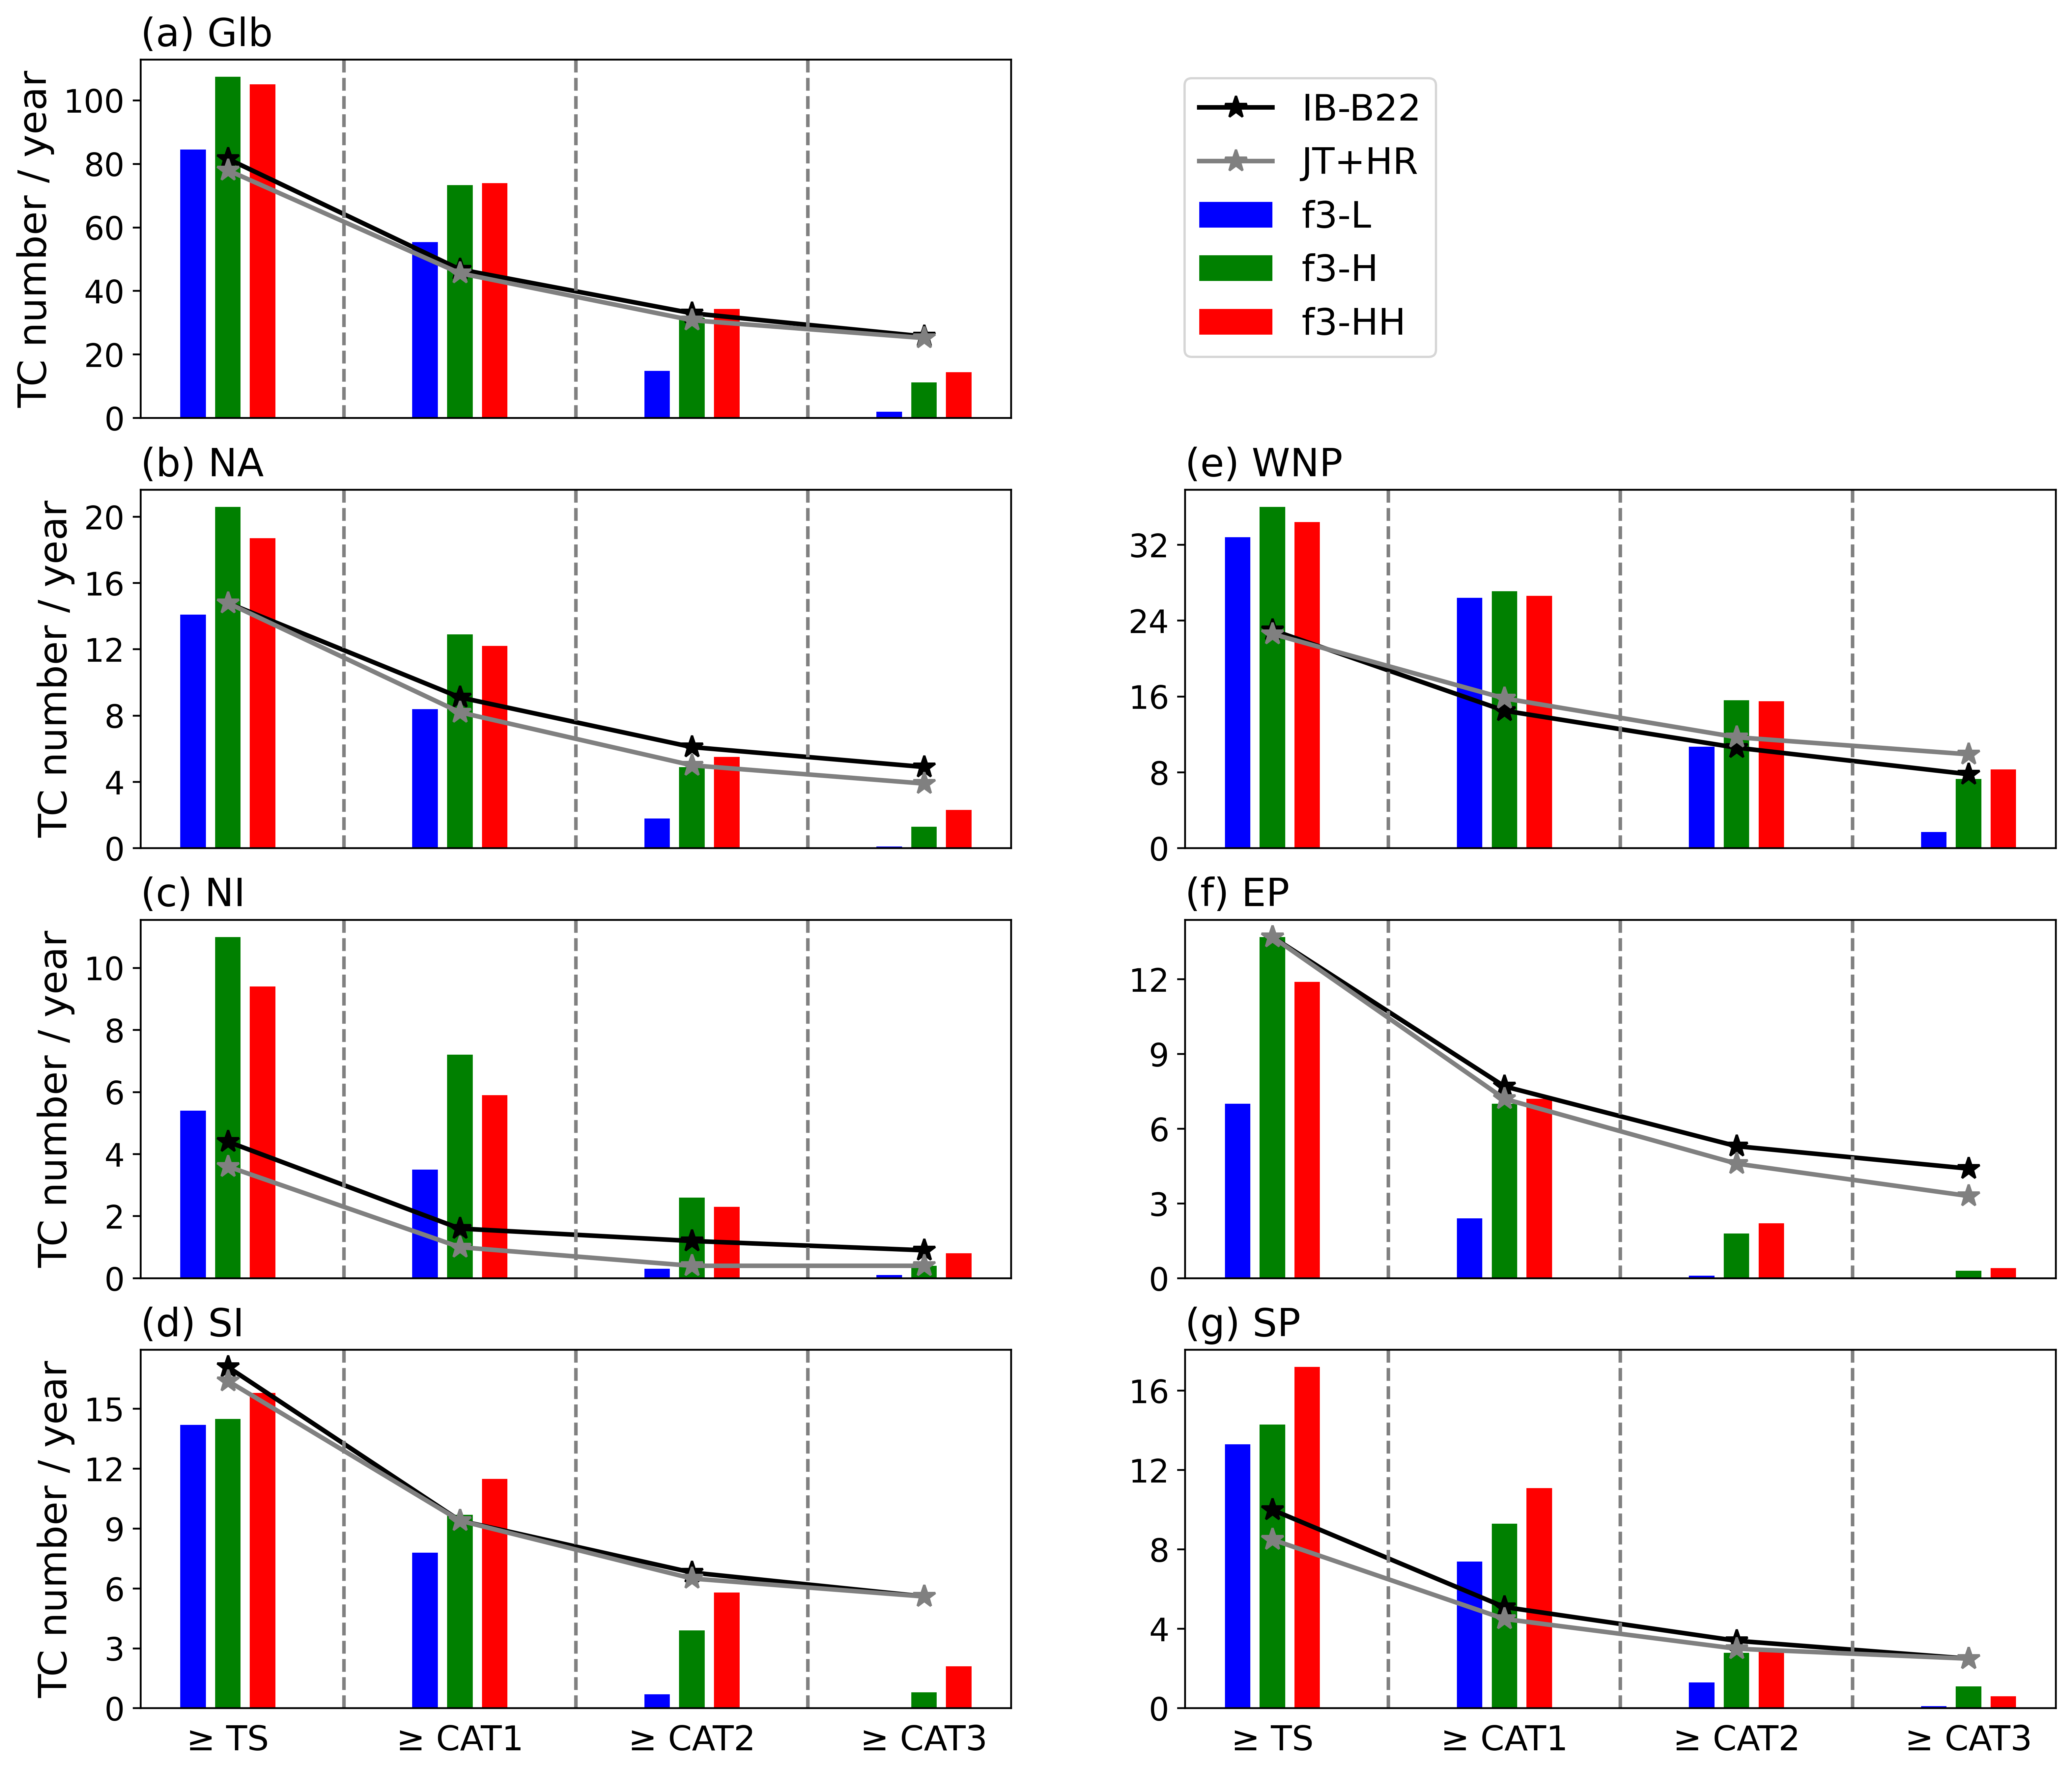

In [6]:
from matplotlib.ticker import MaxNLocator

exp_name_1 = 'IB-B22'
exp_name_2 = 'JT+HR'

exp_name_3 = 'f3-L'
exp_name_4 = 'f3-H'
exp_name_5 = 'f3-HH'

exp_list = [exp_name_1, exp_name_2, exp_name_3, exp_name_4, exp_name_5]

exp_to_check = [exp_name_1, exp_name_2, exp_name_3, exp_name_4, exp_name_5]

line_colors = ['black', 'gray','blue', 'green', 'red']

line_styles = ['-', '--',  '-', '-', '-'] 
line_widths = [2.5, 2.5, 2.5, 2.5, 2.5,]
markers = ['', '', '', '', '']

drop_lim = 2   # 2 means last two CATs are not going to plot 

############################################################################################
# Adjust the cases to use based on drop_lim   # cases[:-drop_lim] if drop_lim > 0 else cases
if drop_lim == 0:
    cases_to_use = cases
else:
    cases_to_use = cases[:-drop_lim]     
############################################################################################
    
# Create a figure
fig, axs = plt.subplots(4, 2, figsize=(15,13))
fig.set_dpi(500)
labels = ['(a)', '(b)', '(c)', '(d)', '()', '(e)', '(f)', '(g)']

# Iterate over basins
for basin_idx, (basin, label) in enumerate(zip(basins, labels)): 
    
    if basin_idx != 4 :  # Skip South Atlantic basin (index 4) - insufficient TC frequency for analysis
        
        # Calculate the row and column index for the current subplot
        row_idx = basin_idx % 4  # Modulo operation to get the row index
        col_idx = basin_idx // 4   # Integer division to get the column index

        # Select the appropriate subplot using the calculated indices
        ax = axs[row_idx, col_idx]  

        # Initialize a dictionary to store observation data for each experiment
        obs_clim = {}    

        # Iterate over each case
        for i, case in enumerate(cases_to_use, start=1):

            catOabv = int(case - 1.9)
            # Get scount values for the current case
            scount_values = scount_values_4D[:,i-1,basin_idx,:]

            mean_scount_values = scount_values / len(y_range)
            mstep_values_d = [(k * 6 / 24) for k in mstep_values] # even if we use 'i' here then that i means this single line inside 'i' relavent to 'mstep_values'

            # Plot lines for each experiment
            for j, (exp_name, style, color, line_width, marker) in enumerate(zip(exp_to_check, 
                                                                                 line_styles, line_colors, line_widths, markers)):

                # exp_index = exp_list.index(exp_name)
                # print(exp_index)
                if exp_name == exp_name_1 or exp_name == exp_name_2 :
                    if exp_name not in obs_clim or not isinstance(obs_clim[exp_name], list):
                        obs_clim[exp_name] = []  # Initialize as an empty list if not exists or not a list
                    obs_clim[exp_name].append(mean_scount_values[0, j])   # here 0 represents 1-day criteria
                else:
                    ax.bar(j*0.15 +catOabv-0.45, mean_scount_values[1, j], width=0.11, label=exp_name, color=color)   # here 1 represents 3-day criteria
            
                    print(f"{exp_name} {basin}: {mean_scount_values[1, j]}")

        # Plot observation lines for each experiment
        for exp_name, color in zip([exp_name_1, exp_name_2], ['black', 'gray']):
            ax.plot(np.arange( len(cases)-drop_lim ), obs_clim[exp_name] , label=exp_name, color=color, linewidth=2, marker='*', markersize=10) 
            
            print(f"{exp_name} {basin}: {obs_clim[exp_name]}")
            
            #ax.set_title(f'[CAT {catOabv} or Above]', fontsize=17)
            if col_idx == 0: 
                ax.set_ylabel('TC number / year', fontsize=17)

            # Set x tick labels
            if row_idx == 3: 
                ax.set_xticks(np.arange(6-drop_lim))
                ax.set_xticklabels(['\u2265 TS', '\u2265 CAT1', '\u2265 CAT2', '\u2265 CAT3'], fontsize=15)  # Custom x tick labels  #  '\u2265 CAT4', '\u2265 CAT5'
            else: 
                ax.set_xticklabels([])  # remove labels

            # Draw box segments for every 7 bars
            for k in range(1, 6-drop_lim):
                ax.axvline(x=k * 1 - 0.5, color='gray', linestyle='--')

            ax.set_title(f'{label} {basin}', fontsize=17, loc='left')
            
            #####################################################################################
            # Set y-axis labels to integers with a max of 6 ticks
            ax.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=6))
            
            # ax.tick_params(axis='x', labelsize=14)  # Increase x-axis tick label font size
            ax.tick_params(axis='y', labelsize=14)  # Increase y-axis tick label font size           
            # Hide the x-axis ticks (but keep the tick labels)
            ax.tick_params(axis='x', which='both', bottom=False, top=False)            
            
            
# To keep the empty space in the grid for subplot 5, you can use fig.delaxes to remove it
fig.delaxes(axs[0, 1])  
    
# Adjust layout and show the plot
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles[:5], labels[:5], loc='upper left', bbox_to_anchor=(0.54, 0.88), fontsize=16)  # Legend with only two lines and 5 bar indicators
#fig.suptitle(f'Number of systems by Intensity Level (Period: {start_year}-{end_year})', fontsize=20)
#plt.tight_layout()

# Save the figure
os.makedirs('../Figure', exist_ok=True)
save_path = '../Figure/07_Annual climatology of the number of TCs.pdf'
plt.savefig(save_path, dpi=600, bbox_inches='tight', format='pdf')
print(f"Figure saved as: {save_path}")    

plt.show()
